In [1]:
import sys
import os
_path = os.path.abspath('../scripts/')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('v4.0')
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.special import logsumexp

from pyia import GaiaData
import theano
# theano.config.gcc.cxxflags = "-fbracket-depth=16000" # default is 256 - only need this on Mac??
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

from model import FieldHelper

Expected mean disk velocity in ICRS:

In [2]:
xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 234, 0])) * u.km/u.s)
vthin = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 200, 0])) * u.km/u.s)
vthik = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vsun = coord.CartesianDifferential(-np.array([12.9, 245.6, 7.78]) * u.km/u.s)
vhalo = coord.SkyCoord(xtmp.with_differentials(vsun), frame='galactic').icrs.velocity.d_xyz.value

vthin, vthik, vhalo

(array([ 1.72666906, 17.96839664, -5.97107496]),
 array([-15.0730518 ,  33.09260716, -31.36846921]),
 array([-113.89493924,  122.05855141, -180.76490601]))

In [3]:
vfield0 = np.stack([vthin, vthik, vhalo])
sigvfield0 = np.stack([20., 50., 125.])

In [4]:
g = GaiaData('../data/150pc_MG12-result.fits.gz')

In [5]:
subg = g[np.isfinite(g.radial_velocity)]
# subg = g
subg = subg[np.random.choice(len(subg), size=1024, replace=False)]
np.isfinite(subg.radial_velocity).sum()

1024

15.97906056103374 -1.7996497438651318
33.356099845368185 18.438641079574637
20.722814480566676 -11.298073015815191
15.550512221101243 -2.48063071798013
35.18374145884981 19.7399139392918
21.473020005783397 -12.177760369414822


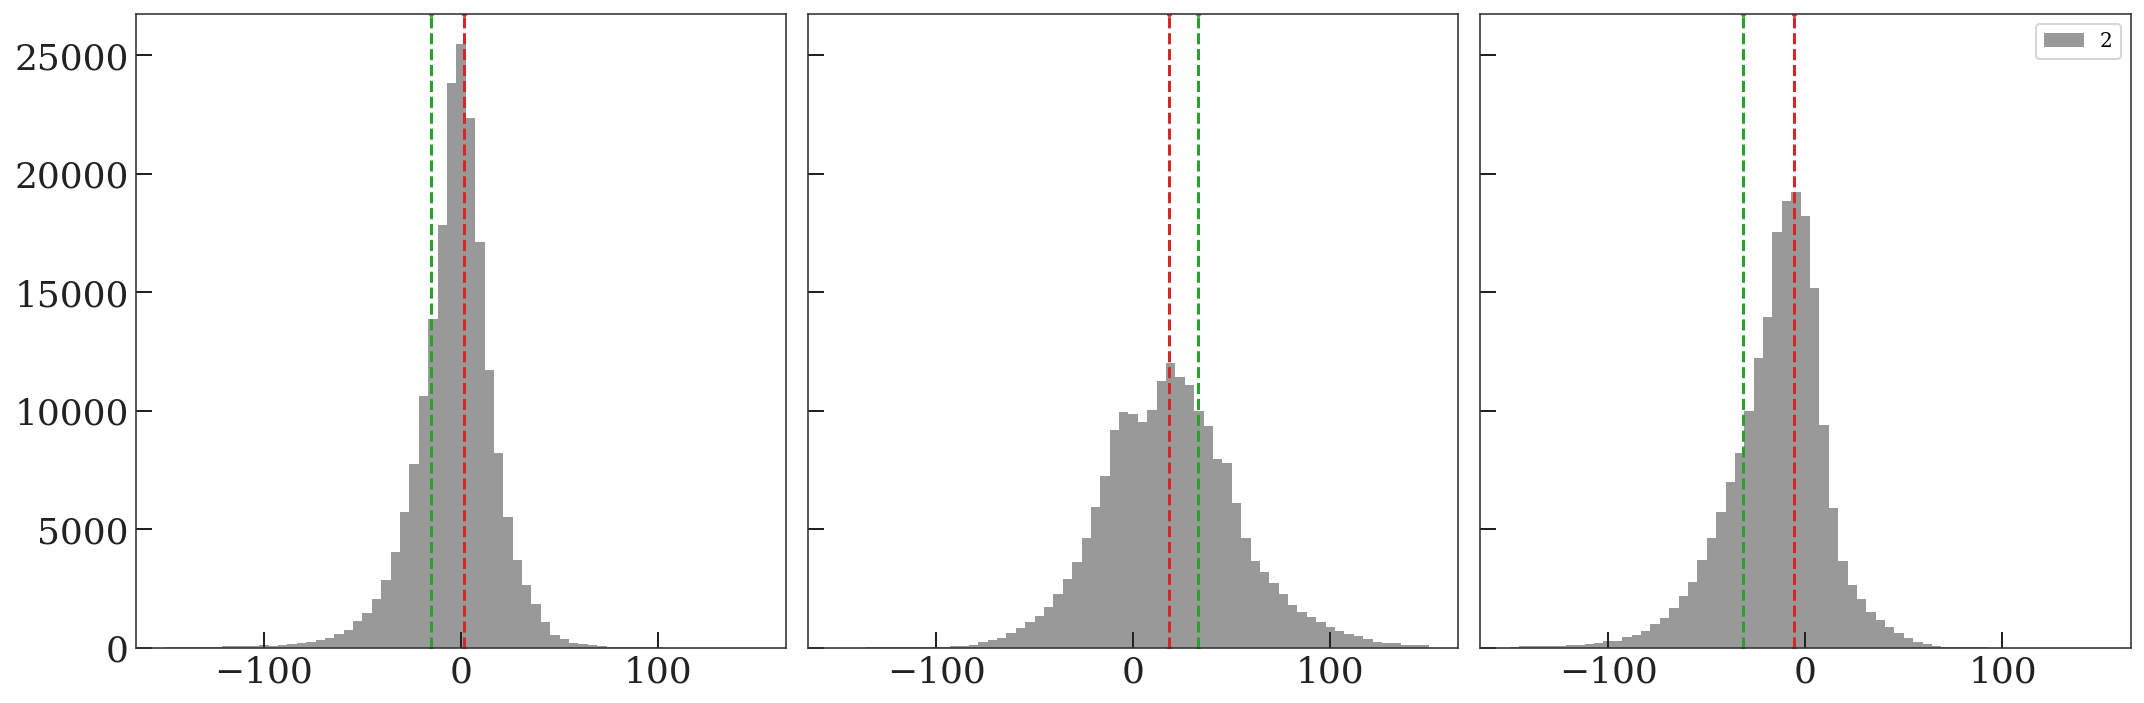

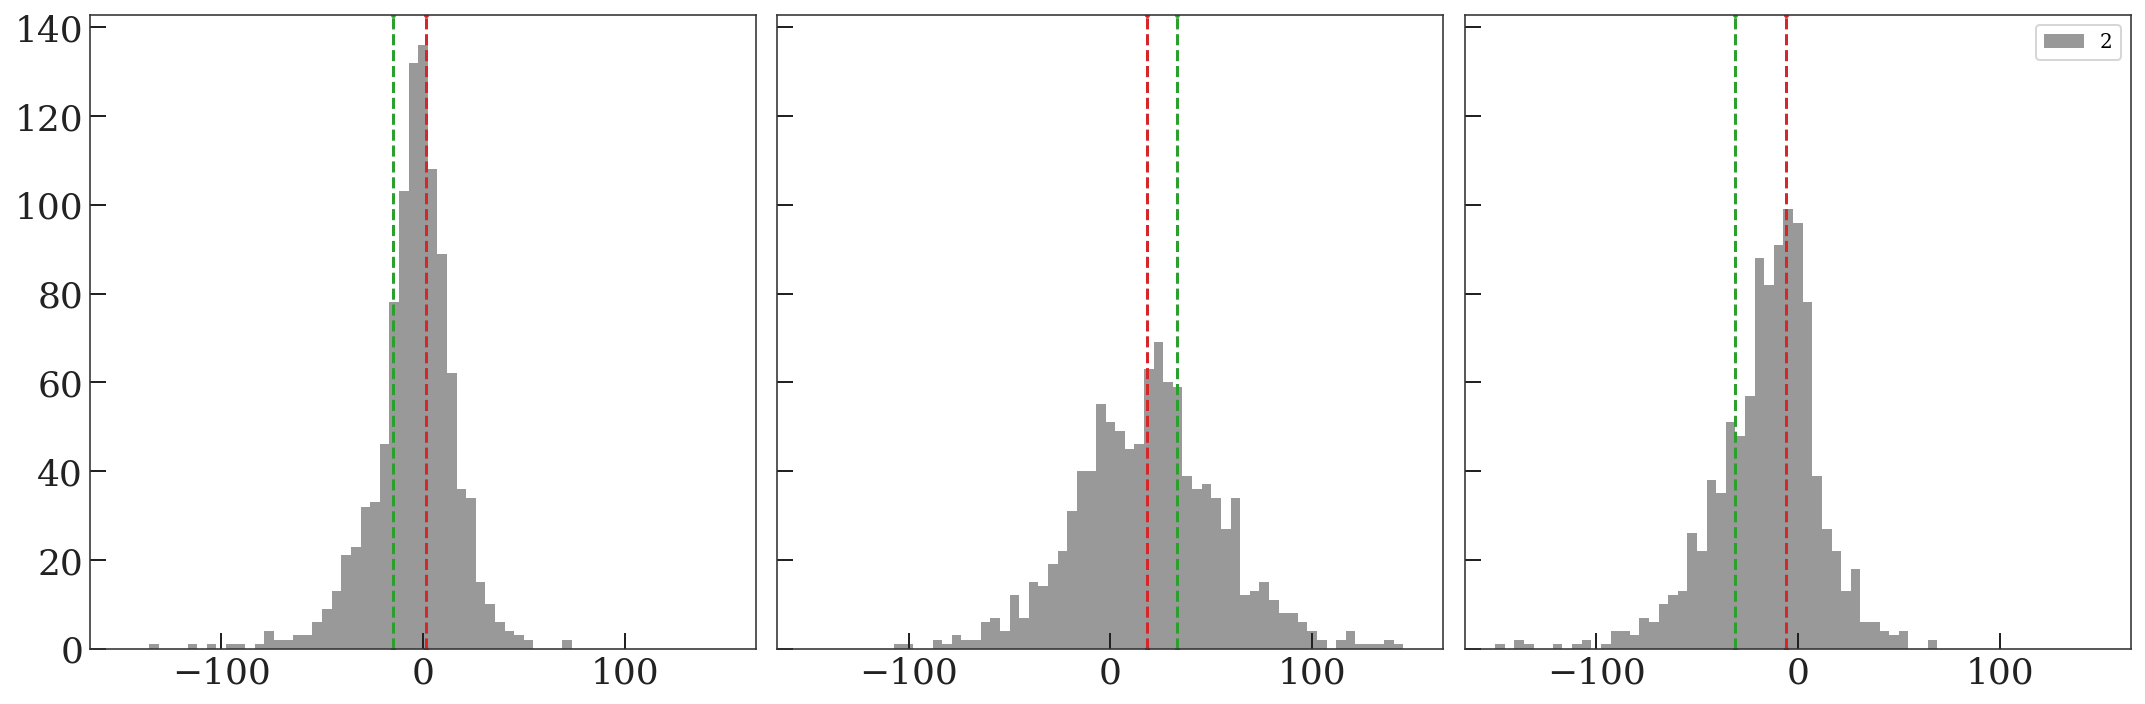

In [6]:
for gg in [g, subg]:
    c = gg.get_skycoord()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    for i in range(3):
        ax = axes[i]

        _x = c.velocity.d_xyz.value[i]
        print(1.5 * np.nanmedian(np.abs(_x - np.nanmedian(_x))),
              np.nanmedian(_x))
        ax.hist(c.velocity.d_xyz.value[i],
                bins=np.linspace(-150, 150, 64), alpha=0.4, label=str(i));

        ax.axvline(vthin[i], color='tab:red', linestyle='--')
        ax.axvline(vthik[i], color='tab:green', linestyle='--')

    ax.legend(loc='best')
#     ax.set_yscale('log')

    fig.tight_layout()

In [7]:
from model import BaseHelper, UniformSpaceDensity, pc_mas_yr_per_km_s
class FieldHelper(BaseHelper):

    def get_model(self, vfield0, sigma_vfield0):
        # Number of prior mixture components:
        with pm.Model() as model:

            # True distance:
            rlim = 250.
            BoundedR = pm.Bound(UniformSpaceDensity, lower=0, upper=rlim)
            r = BoundedR("r", rlim, shape=(self.N, 1))

            # Milky Way velocity distribution
            K = vfield0.shape[0]
            w = pm.Dirichlet('w', a=np.ones(K))

            # Set up means and variances:
            meanvs = []
            sigvs = []
            for k in range(K):
                vtmp = pm.Normal(f'vmean{k}', vfield0[k], 10., shape=3)  # HACK

                BoundedNormal = pm.Bound(pm.Normal, lower=1.5, upper=5.3)
                lnstmp = BoundedNormal(f'lns{k}',
                                       np.log(sigma_vfield0[k]), 0.5)
                stmp = pm.Deterministic(f'vsig{k}', tt.exp(lnstmp))

                meanvs.append(vtmp)
                sigvs.append(stmp)

            pvdists = []
            for k in range(K):
                pvtmp = pm.Normal.dist(meanvs[k], sigvs[k], shape=3)
                pvdists.append(pvtmp)
            vxyz = pm.Mixture('vxyz', w=w,
                              comp_dists=pvdists, shape=(self.N, 3))

            # Velocity in tangent plane coordinates
            vtan = tt.batched_dot(self.Ms, vxyz)

            model_pm = vtan[:, :2] / r * pc_mas_yr_per_km_s
            model_rv = vtan[:, 2:3]
            model_y = tt.concatenate((1000 / r, model_pm, model_rv), axis=1)

            pm.Deterministic('model_y', model_y)
            # val = pm.MvNormal('like', mu=model_y, tau=Cinv, observed=y)
            dy = self.ys - model_y
            pm.Potential('chisq',
                         -0.5 * tt.batched_dot(dy,
                                               tt.batched_dot(self.Cinvs, dy)))

        return model

In [8]:
helper = FieldHelper(subg)
model = helper.get_model(vfield0, sigvfield0)

In [9]:
with model:
    res = xo.optimize(start={'vxyz': helper.test_vxyz,
                             'r': helper.test_r,
                             'w': np.array([0.5, 0.4, 0.1]),
                             'vmean0': vfield0[0],
                             'vmean1': vfield0[1],
                             'vmean2': vfield0[2],
                             'lns0': np.log(sigvfield0[0]),
                             'lns1': np.log(sigvfield0[1]),
                             'lns2': np.log(sigvfield0[2])})

optimizing logp for variables: [vxyz, lns2, vmean2, lns1, vmean1, lns0, vmean0, w, r]


message: Desired error not necessarily achieved due to precision loss.
logp: -17186.230338312515 -> -16825.97109683195


In [10]:
res['w']

array([0.53161301, 0.46602227, 0.00236472])

In [11]:
res

{'r_interval__': array([[ 0.34262353],
        [-0.36966488],
        [-0.67790934],
        ...,
        [-1.3354404 ],
        [-0.48527341],
        [ 0.14052107]]),
 'w_stickbreaking__': array([0.81976812, 5.28357298]),
 'vmean0': array([-1.49966296, 14.54365055, -9.39127686]),
 'lns0_interval__': array(-0.74374448),
 'vmean1': array([ -8.78150468,  22.08294278, -22.9100212 ]),
 'lns1_interval__': array(0.22715676),
 'vmean2': array([-112.0987016 ,  120.8536385 , -179.84992332]),
 'lns2_interval__': array(1.66535339),
 'vxyz': array([[  0.27954239, -23.56614041, -43.36353426],
        [-18.49416301,   8.44732211,   8.11677688],
        [-24.72730243, -74.56483298, -74.38555531],
        ...,
        [ -6.37638814,  45.99299025,   6.02114101],
        [-14.78500842, -25.91111688, -29.85407603],
        [ -4.08476297,  15.76090947, -13.7066991 ]]),
 'r': array([[146.20691704],
        [102.15549994],
        [ 84.18201923],
        ...,
        [ 52.06522066],
        [ 95.2519152 ],

In [14]:
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

def logmixprob(vxyz):
    ps = []
    for k in range(3):
        ps.append(multivariate_normal.logpdf(vxyz, res[f'vmean{k}'], 
                                             cov=np.eye(3)*res[f'vsig{k}']**2) + np.log(res['w'][k]))
    return logsumexp(ps, axis=0)

15.97906056103374 -1.7996497438651318
33.356099845368185 18.438641079574637
20.722814480566676 -11.298073015815191


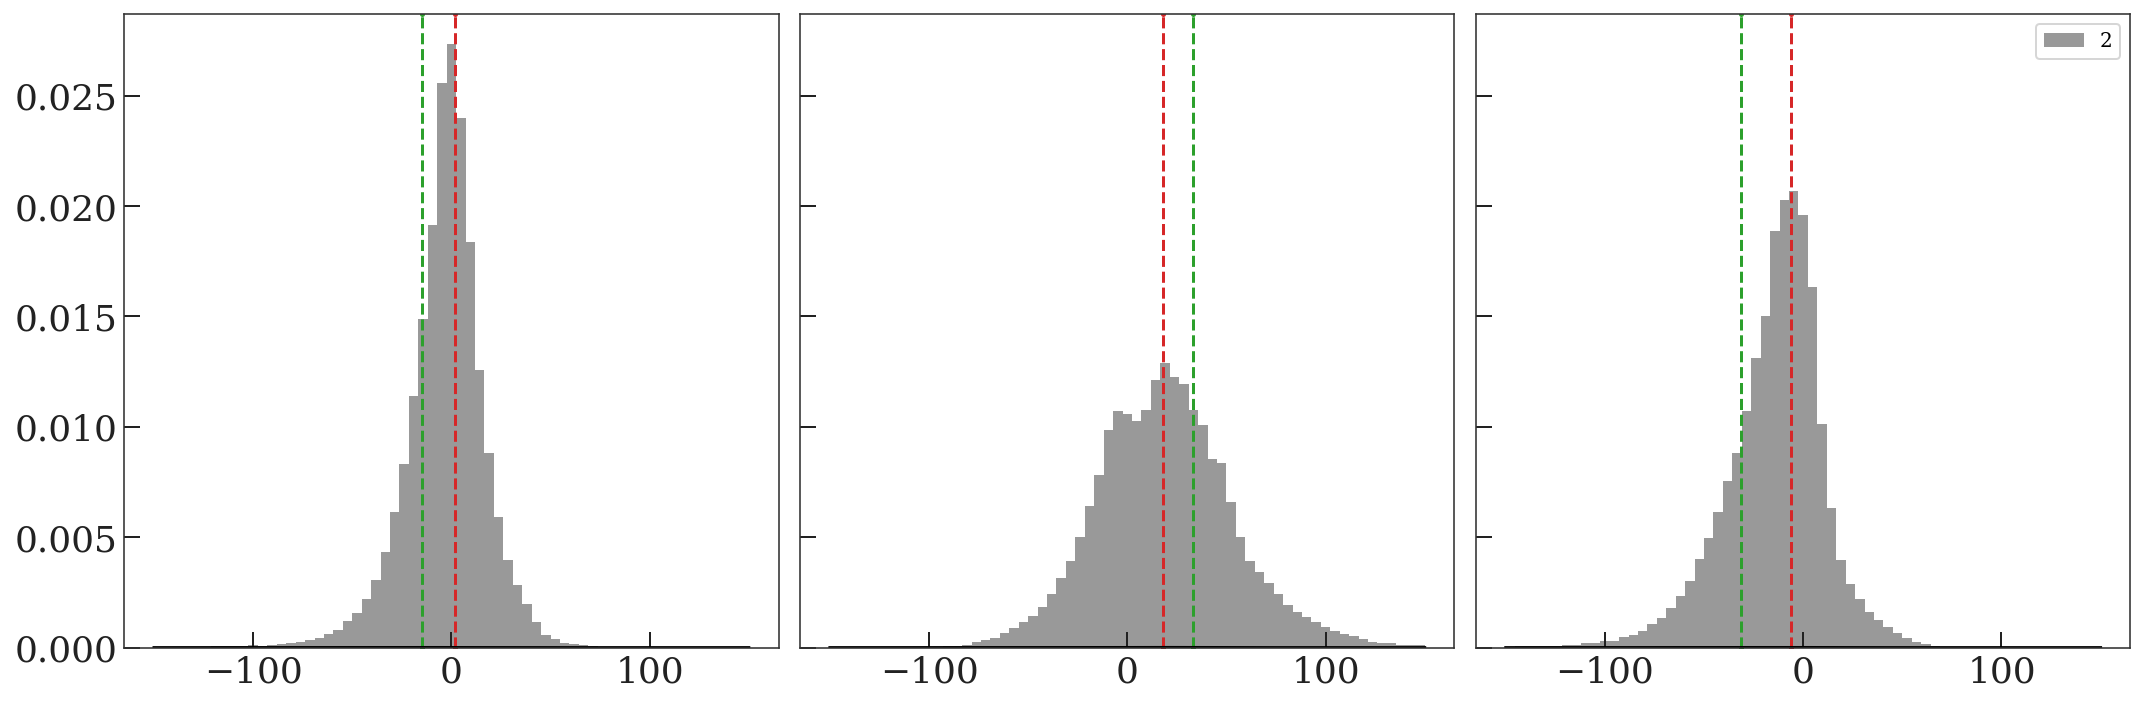

In [18]:
c = g.get_skycoord()

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i in range(3):
    ax = axes[i]

    _x = c.velocity.d_xyz.value[i]
    print(1.5 * np.nanmedian(np.abs(_x - np.nanmedian(_x))),
          np.nanmedian(_x))
    ax.hist(c.velocity.d_xyz.value[i],
            bins=np.linspace(-150, 150, 64), alpha=0.4, 
            label=str(i), color='k', density=True);

    ax.axvline(vthin[i], color='tab:red', linestyle='--')
    ax.axvline(vthik[i], color='tab:green', linestyle='--')
    
    vxyz = np.zeros((1024, 3))
    vxyz[:, i] = np.linspace(-150, 150, vxyz.shape[0])
    ax.plot(vxyz[:, i], np.exp(logmixprob(vxyz)), marker='') # TODO: why is this not normalized right? marginal?

ax.legend(loc='best')

fig.tight_layout()